<h1>Company: Alphabet Inc. (GOOG)</h1>
<h3>Data set used: 8/19/2004 - 11/3/2018</h3>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
from scipy.stats import zscore
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import numpy as np


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def to_sequences(seq_size, data, target):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
#        print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
#       after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
#        print("{} - {}\n".format(window,after_window))
        x.append(window)
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

In [3]:
path = "./data/"
    
filename = os.path.join(path,"GOOG.csv")
df = pd.read_csv(filename, na_values=['NA','?'])

df_work=df.drop(columns=['Date','Adj Close'], axis=1)

In [4]:
df.shape

(3579, 7)

<h3>Feature Normalization</h3>

In [5]:
df_work['Open']=zscore(df_work['Open'])
df_work['High'] = zscore(df_work['High'])
df_work['Low'] = zscore(df_work['Low'])
df_work['Volume'] = zscore(df_work['Volume'])

x1 = df_work['Open'].values.reshape( len(df['Open']),1)
x2 = df_work['High'].values.reshape( len(df['High']),1)
x3 = df_work['Low'].values.reshape( len(df['Low']),1)
x4 = df_work['Volume'].values.reshape( len(df['Volume']),1)

<h3>Fully-Connected Neural Network</h3>

In [6]:
import math as Math
x = np.concatenate([x1,x2,x3,x4],axis=1)
y = df_work['Close']
# Split into train/test
train_set_size = x.shape[0] * 0.70
train_set_size = Math.ceil(train_set_size)

x_train = x[0:train_set_size]
x_test = x[train_set_size+1 : x.shape[0]]
y_train = y[0:train_set_size]
y_test = y[train_set_size+1 : x.shape[0]]
print(x.shape)

(3579, 4)


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

model = Sequential()
model.add(Dense(467, input_dim=x.shape[1], activation='relu'))
model.add(Dense(363, activation='relu'))
model.add(Dense(672, activation='relu'))
model.add(Dense(82, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')  
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model


Using TensorFlow backend.


In [8]:
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)  
model.load_weights('best_weights.hdf5')
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
score = r2_score(y_test, pred)  
print(score)

Train on 2506 samples, validate on 1072 samples
Epoch 1/1000
2506/2506 [==============================] - 1s 212us/step - loss: 31471.5464 - val_loss: 47537.6893
Epoch 2/1000
2506/2506 [==============================] - 0s 97us/step - loss: 4412.2506 - val_loss: 12334.6806
Epoch 3/1000
2506/2506 [==============================] - 0s 108us/step - loss: 551.8890 - val_loss: 60.3084
Epoch 4/1000
2506/2506 [==============================] - 0s 101us/step - loss: 17.2546 - val_loss: 51.1340
Epoch 5/1000
2506/2506 [==============================] - 0s 106us/step - loss: 12.9828 - val_loss: 113.1366
Epoch 6/1000
2506/2506 [==============================] - 0s 100us/step - loss: 11.9713 - val_loss: 145.5090
Epoch 7/1000
2506/2506 [==============================] - 0s 98us/step - loss: 10.5662 - val_loss: 137.5261
Epoch 8/1000
2506/2506 [==============================] - 0s 99us/step - loss: 12.4906 - val_loss: 102.0049
Epoch 9/1000
2506/2506 [==============================] - 0s 103us/step - l

2506/2506 [==============================] - 0s 111us/step - loss: 9.0803 - val_loss: 36.6904
Epoch 76/1000
2506/2506 [==============================] - 0s 117us/step - loss: 12.6182 - val_loss: 26.0280
Epoch 77/1000
2506/2506 [==============================] - 0s 107us/step - loss: 12.4373 - val_loss: 31.2175
Epoch 78/1000
2506/2506 [==============================] - 0s 123us/step - loss: 20.6379 - val_loss: 53.9460
Epoch 79/1000
2506/2506 [==============================] - 0s 110us/step - loss: 10.3960 - val_loss: 45.6464
Epoch 80/1000
2506/2506 [==============================] - 0s 108us/step - loss: 6.3463 - val_loss: 207.7173
Epoch 81/1000
2506/2506 [==============================] - 0s 109us/step - loss: 9.0733 - val_loss: 97.0515
Epoch 82/1000
2506/2506 [==============================] - 0s 106us/step - loss: 13.9526 - val_loss: 368.5933
Epoch 83/1000
2506/2506 [==============================] - 0s 104us/step - loss: 19.2070 - val_loss: 57.9000
Epoch 84/1000
2506/2506 [=========

<h3>Regression Lift Chart : Fully-connected Neural Network</h3>

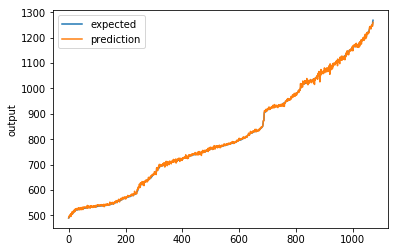

In [9]:
y_test_array = y_test.values.reshape( len(y_test),1)
pred_list=pred.flatten()
y_test_list = y_test_array.flatten()
chart_regression(pred_list,y_test_list)

<h3>RNN : Based on Last 7 days data</h3>

In [10]:
df=df.drop(columns=['Date','Adj Close'], axis=1)
df_work['Close'] = zscore(df_work['Close'])
x5 = df_work['Close'].values.reshape( len(df['Close']),1)

In [11]:
train_set_size = df_work.shape[0] * 0.70
train_set = Math.ceil(train_set_size)
df_train = df_work[0:train_set]
df_test = df_work[train_set+1 : df_work.shape[0]]

close_train = df_train.values
close_test = df_test.values
train_unnormalise_close = df[0:train_set]
test_unnormalise_close = df[train_set+1 : df_work.shape[0]]
train_unnormalise_close = train_unnormalise_close['Close'].tolist()
test_unnormalise_close =test_unnormalise_close['Close'].tolist()

print("Training set has {} records.".format(len(close_train)))
print("Test set has {} records.".format(len(close_test)))

Training set has 2506 records.
Test set has 1072 records.


In [12]:
SEQUENCE_SIZE = 7

x_train,y_train = to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (2498, 7, 5)
Shape of x_test: (1064, 7, 5)
Shape of y_train: (2498,)
Shape of y_test: (1064,)


In [13]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()

model.add(LSTM(200, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5), activation='relu'))
model.add(Dense(163, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
print('Train...')
for rnn_fit in range(3):
    model.fit(x_train,y_train,
              validation_data=(x_test,y_test),
              callbacks=[monitor],verbose=2, epochs=500)
    pred_rnn = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred_rnn,y_test))
    print("Score (RMSE): {}".format(score))
    score = r2_score(y_test, pred_rnn)  
    print("Score (R2): {}".format(score))

Build model...
Train...
Train on 2498 samples, validate on 1064 samples
Epoch 1/500
 - 1s - loss: 29896.0041 - val_loss: 439884.1867
Epoch 2/500
 - 1s - loss: 4673.2067 - val_loss: 273423.5143
Epoch 3/500
 - 1s - loss: 3078.5599 - val_loss: 21675.3911
Epoch 4/500
 - 1s - loss: 2298.8098 - val_loss: 69732.7342
Epoch 5/500
 - 1s - loss: 2096.3081 - val_loss: 393204.5465
Epoch 6/500
 - 1s - loss: 1800.8515 - val_loss: 17219.8650
Epoch 7/500
 - 1s - loss: 1410.7576 - val_loss: 16730.5099
Epoch 8/500
 - 1s - loss: 1320.3306 - val_loss: 18443.2991
Epoch 9/500
 - 1s - loss: 1158.2339 - val_loss: 31582.5243
Epoch 10/500
 - 1s - loss: 1050.8261 - val_loss: 42092.7829
Epoch 11/500
 - 1s - loss: 965.9398 - val_loss: 27309.6099
Epoch 12/500
 - 1s - loss: 873.8368 - val_loss: 12243.4987
Epoch 13/500
 - 1s - loss: 824.0814 - val_loss: 2469.1735
Epoch 14/500
 - 1s - loss: 744.8069 - val_loss: 7557.6808
Epoch 15/500
 - 1s - loss: 669.2266 - val_loss: 3702.4451
Epoch 16/500
 - 1s - loss: 668.1296 - val

Epoch 36/500
 - 1s - loss: 115.8363 - val_loss: 3836.7679
Epoch 37/500
 - 1s - loss: 127.7796 - val_loss: 793.7739
Epoch 38/500
 - 1s - loss: 119.4464 - val_loss: 899.2057
Epoch 39/500
 - 1s - loss: 127.8736 - val_loss: 3718.9781
Epoch 40/500
 - 1s - loss: 122.1935 - val_loss: 1795.8111
Epoch 41/500
 - 1s - loss: 122.0478 - val_loss: 294.6262
Epoch 42/500
 - 1s - loss: 126.3496 - val_loss: 932.0234
Epoch 43/500
 - 1s - loss: 128.4360 - val_loss: 3958.0847
Epoch 44/500
 - 1s - loss: 118.9455 - val_loss: 1408.9573
Epoch 45/500
 - 1s - loss: 120.4216 - val_loss: 8983.3974
Epoch 46/500
 - 1s - loss: 122.8850 - val_loss: 8987.2111
Epoch 47/500
 - 1s - loss: 118.3212 - val_loss: 502.1521
Epoch 48/500
 - 1s - loss: 112.6576 - val_loss: 2286.7858
Epoch 49/500
 - 1s - loss: 123.3791 - val_loss: 419.8832
Epoch 50/500
 - 1s - loss: 125.0069 - val_loss: 530.2782
Epoch 51/500
 - 1s - loss: 121.5108 - val_loss: 464.6119
Epoch 52/500
 - 1s - loss: 118.4287 - val_loss: 6330.7428
Epoch 53/500
 - 1s - l

<h4>Regression Lift Chart: RNN</h4>

(1064, 1)
(1064,)


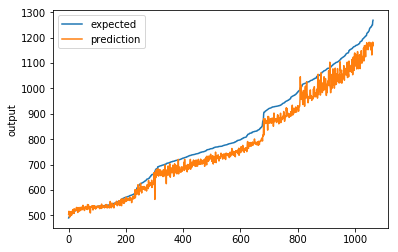

In [14]:
print(pred_rnn.shape)
print(y_test.shape)
pred_list=pred_rnn.flatten()
chart_regression(pred_list,y_test)

<h3>CNN</h3>

In [15]:
def cnn_to_sequences(seq_size, data, target):
    x = []
    y = []

    print(len(data)-SEQUENCE_SIZE-1)
    for i in range(len(data)-SEQUENCE_SIZE-1):
        window = data[i:(i+SEQUENCE_SIZE)]
        window = [x for x in window]
        x.append([window])
        y.append(target[i+SEQUENCE_SIZE])
        
    return np.array(x),np.array(y)

In [16]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

SEQUENCE_SIZE = 7

x_train,y_train = cnn_to_sequences(SEQUENCE_SIZE,close_train,train_unnormalise_close)
x_test,y_test = cnn_to_sequences(SEQUENCE_SIZE,close_test,test_unnormalise_close)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

2498
1064
Shape of x_train: (2498, 1, 7, 5)
Shape of x_test: (1064, 1, 7, 5)
Shape of y_train: (2498,)
Shape of y_test: (1064,)


In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [18]:
input_shape = (1, 7, 5)
cnn2d = Sequential()
cnn2d.add(Conv2D(67, kernel_size=(1, 4), strides=(3, 3), activation='relu',
                 input_shape=input_shape))  
cnn2d.add(Conv2D(43, kernel_size = (1, 3), activation='relu', padding= 'same'))
cnn2d.add(Conv2D(28, kernel_size = (1, 2), activation='relu', padding = 'same'))
# cnn2d.add(Conv2D(50, kernel_size = (1, 2), activation='relu', padding = 'same'))
cnn2d.add(Flatten())
cnn2d.add(Dense(1, activation='relu'))

cnn2d.compile(optimizer='adam',
              loss='mean_squared_error')

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
cnn2d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 2, 67)          1407      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 43)          8686      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 2, 28)          2436      
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 57        
Total params: 12,586
Trainable params: 12,586
Non-trainable params: 0
_________________________________________________________________


In [19]:
import time
from sklearn import metrics

start_time = time.time()
for cnn_fit in range(2):
    cnn2d.fit(x_train, y_train,     
              epochs=1000,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    pred = cnn2d.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score))
    score = r2_score(y_test, pred)  
    print("Score (R2): {}".format(score))

Train on 2498 samples, validate on 1064 samples
Epoch 1/1000
 - 0s - loss: 88115.0044 - val_loss: 697964.9182
Epoch 2/1000
 - 0s - loss: 85198.6325 - val_loss: 673042.8788
Epoch 3/1000
 - 0s - loss: 71007.3879 - val_loss: 543715.6095
Epoch 4/1000
 - 0s - loss: 50249.2584 - val_loss: 280602.5284
Epoch 5/1000
 - 0s - loss: 37008.9860 - val_loss: 45608.8420
Epoch 6/1000
 - 0s - loss: 23073.1998 - val_loss: 270952.9809
Epoch 7/1000
 - 0s - loss: 14922.6034 - val_loss: 755088.4316
Epoch 8/1000
 - 0s - loss: 12792.5413 - val_loss: 459955.6172
Epoch 9/1000
 - 0s - loss: 11350.2596 - val_loss: 303687.7854
Epoch 10/1000
 - 0s - loss: 10193.6368 - val_loss: 245824.3365
Epoch 11/1000
 - 0s - loss: 9167.9792 - val_loss: 168637.0718
Epoch 12/1000
 - 0s - loss: 8202.0038 - val_loss: 116542.9739
Epoch 13/1000
 - 0s - loss: 7319.1968 - val_loss: 75948.9993
Epoch 14/1000
 - 0s - loss: 6482.4297 - val_loss: 47362.4187
Epoch 15/1000
 - 0s - loss: 5671.8154 - val_loss: 27379.4888
Epoch 16/1000
 - 0s - los

<h3>Regression Lift Chart: CNN</h3>

(1064, 1)
(1064,)


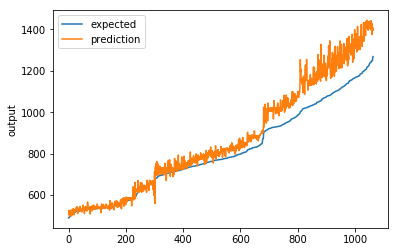

In [20]:
print(pred.shape)
print(y_test.shape)
pred_list=pred.flatten()
chart_regression(pred_list,y_test)